# Table of Contents
1. [Introduction](#intro)
2. [Installing required packages](#install)
3. [Loading  Datasets and Data Description](#data)
    * 3.1.[Fact Market Demand Data](#fact)
    * 3.2.[Customer Demographics Data](#demograpic)
    * 3.3.[Zip Code Data](#zip)
    * 3.4 [Missing Data](#missing)
4. [Modeling](#modeling)  
    * 4.1.[Autoregression (AR) Model](#ar)
    * 4.2.[ARIMA Model](#arima)
        - 4.2.1 [Question 1 with ARIMA](#aq1)
        - 4.2.2 [Question 3 with ARIMA](#aq3)
5. [Conclusion](#Conclusion)
6. [Contribution](#group)

# <a name="intro"></a> 1. Introduction

Swire Coca-Cola  is continually introducing innovative products into the market. Innovation diversifies product offerings, meeting evolving consumer trends. This strategy, marked by unique products and premium pricing, expands market reach and attracts new customers. It responds to technology changes and regulations, ensuring cost efficiency and compliance. Additionally, it rejuvenates sales and marketing. In essence, product innovation is essential for staying relevant, driving revenue, and sustaining long-term growth in a dynamic market.

So, Swire Coca-Cola wants to optimize its production planning and inventory management for these novel beverages. The challenge for Swire is to forecast the demand for these new products accurately to ensure optimal production quantities, prevent out-of-stock and overproduction, minimize costs, and maximize customer satisfaction. The Business problem is to accurately predict the weekly demand of the innovation products. The focus of our project will be on optimal production planning, cost minimization, and market location and date prediction.



The Analytical Problem is to forecast the details expected by the Swire for the 7 innovation products that are planned to be launched in the near future. The basic details of each of the new innovation products are provided so that it can be compared against the historical data and can be used to forecast the sales of the innovation products as close as possible to the real time sales.

The key factors for the Items are the Caloric Segment, Market Category, Manufacturer, Brand, Package Type and Flavor which will be used as the independent variables from the Previous years data to create a Forecast for the new innovation Products. So, the Target variable is the Dollar Sales/unit sales for the innovation products.


In this notebook we will create the forecasting models to predict the demand for the new innovation products that the Swire team is expecting to launch in the next year. The scope includes creating the end-to-end development of the forecasting models to find the pattern of the sales for the products and also to discover some insights for improving the sales of innovation products.  It aims to provide Swire with the insights and tools necessary to maintain its Sales while making data-driven decisions that can contribute to the success of the innovation Products.

# <a name="install"></a>2. Installing required packages

In [ ]:
import warnings
warnings.filterwarnings("ignore")



In [ ]:
!pip install google.cloud.bigquery

In [ ]:
import os
import numpy as np
import pandas as pd
import math
import itertools
from scipy import stats
import time


#matplotlib libraries
import matplotlib.pyplot as plt
import matplotlib.patches as mp
import matplotlib.image as mpimg
import matplotlib.cm as cm
import matplotlib.colors
import seaborn as sns

#date libraries
from dateutil import parser
from datetime import datetime, timedelta, date
import holidays

#prophet library
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation

#xgboost
from xgboost import XGBRegressor

#sklearn
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from itertools import combinations
from statsmodels.tsa.ar_model import AutoReg
from itertools import combinations
from scipy.optimize import fminbound


In [ ]:

#pandas options
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#matplotlib setting defaults
sns.set(
        rc={
 "axes.axisbelow": False,
 "axes.edgecolor": "lightgrey",
 "axes.facecolor": "None",
 "axes.grid": False,
 "axes.labelcolor": "dimgrey",
 "axes.spines.right": False,
 "axes.spines.top": False,
 "figure.facecolor": "white",
 "lines.solid_capstyle": "round",
 "patch.edgecolor": "w",
 "patch.force_edgecolor": True,
 "text.color": "dimgrey",
 "xtick.bottom": False,
 "xtick.color": "dimgrey",
 "xtick.direction": "out",
 "xtick.top": False,
 "ytick.color": "dimgrey",
 "ytick.direction": "out",
 "ytick.left": False,
 "ytick.right": False})


In [ ]:
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas as pd

from google.colab import auth

# Authenticate user
auth.authenticate_user()

In [ ]:
# Create a BigQuery client
client = bigquery.Client(project='is-6813-spring-24')

# <a name="data"></a> 3. Loading  Datasets and Data Description

## <a name = "fact"> </a> 3.1 Fact Market Demand Data

The main data file is the fact_market_demand data since that seems to hold the most value for answering the business problem. There are 10 fields and 24,461,424 rows. The columns are data, unit_sales, caloric_segment, category, manufacturer, brand, package, item, market_key and dollar_sales.

The date range is nearly three full years, spanning December 2020 to October 2023. The caloric segment is a categorical column with values Regular and Diet/light.


In [ ]:
# Get Fact_Market_Demand Data from BigQuery

fact_demand_query = """
select * from `swire.fact_market_demand`
"""
# Execute the query
fact_demand_query_job = client.query(fact_demand_query)

# Get the results as a Pandas DataFrame
Fact_Demand_data = fact_demand_query_job.to_dataframe()

# Display Fact_market_demand data
Fact_Demand_data.head()

,DATE,MARKET_KEY,CALORIC_SEGMENT,CATEGORY,UNIT_SALES,DOLLAR_SALES,MANUFACTURER,BRAND,PACKAGE,ITEM
0,2020-12-26,530,DIET/LIGHT,ENERGY,64.00,131.12,PONYS,MYTHICAL BEVERAGE DRAGON TEA,16SMALL MULTI CUP,MYTHICAL BEVERAGE LIZARD DRINK DRINK FLAVOR...
1,2023-04-29,849,DIET/LIGHT,SSD,30.00,194.93,JOLLYS,HILL MOISTURE ZERO SUGAR SPARK,12SMALL 12ONE CUP,RAINING ZERO SUGAR SPARK GENTLE DRINK RAZZ AD...
2,2021-03-27,966,DIET/LIGHT,SSD,18.00,83.16,COCOS,DIET BUBBLE JOY ADVANTAGEOUS CF,12SMALL 8ONE SHADYES JUG,DIET BUBBLE JOY ADVANTAGEOUS CAFFEINE FREE GEN...
3,2022-12-17,303,DIET/LIGHT,SSD,231.00,1148.06,COCOS,DIET BUBBLE JOY ADVANTAGEOUS CF,12SMALL 12ONE CUP,DIET BUBBLE JOY ADVANTAGEOUS CAFFEINE FREE GEN...
4,2022-07-23,464,REGULAR,SSD,132.00,797.68,COCOS,MEXICAN BUBBLE JOY ADVANTAGEOUS,12SMALL 4ONE PLASTICS JUG,KOOL! GENTLE DRINK COLA JUG 12 LIQUID SMALL X4


In [ ]:
# Get a summary of the dataset
print(Fact_Demand_data.describe())

       MARKET_KEY  UNIT_SALES  DOLLAR_SALES
count 24461424.00 24461424.00   24461424.00
mean       593.14      174.37        591.14
std        605.88      857.81       3040.54
min          1.00        0.04          0.01
25%        260.00       11.00         36.59
50%        547.00       40.00        135.05
75%        845.00      126.00        427.14
max       6802.00    96776.00     492591.07


In [ ]:
print(Fact_Demand_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24461424 entries, 0 to 24461423
Data columns (total 10 columns):
 #   Column           Dtype  
---  ------           -----  
 0   DATE             dbdate 
 1   MARKET_KEY       Int64  
 2   CALORIC_SEGMENT  object 
 3   CATEGORY         object 
 4   UNIT_SALES       float64
 5   DOLLAR_SALES     float64
 6   MANUFACTURER     object 
 7   BRAND            object 
 8   PACKAGE          object 
 9   ITEM             object 
dtypes: Int64(1), dbdate(1), float64(2), object(6)
memory usage: 1.8+ GB
None


In [ ]:
# Check for missing values
print(Fact_Demand_data.isnull().sum())

DATE                   0
MARKET_KEY             0
CALORIC_SEGMENT    59725
CATEGORY               0
UNIT_SALES             0
DOLLAR_SALES           0
MANUFACTURER           0
BRAND                  0
PACKAGE                0
ITEM                   0
dtype: int64




In the Fact Demand data we can see that there are 59725 missing data in the CALORIC_SEGMENT Column. Before replacing that let us look at how the CALORIC_SEGMENT data is disctributed by using the count SQL query from Big Query as the processing time will be more if done from dataframe object.



In [ ]:
# Get Caloric Segment data from Fact_Market_Demand Data from BigQuery

CS_query = """
select CALORIC_SEGMENT,
count(*) as Count_caloric_segment
from `swire.fact_market_demand`
group by CALORIC_SEGMENT;
"""
# Execute the query
CS_job = client.query(CS_query)

# Get the results as a Pandas DataFrame
CS_data = CS_job.to_dataframe()

CS_data.head()

,CALORIC_SEGMENT,Count_caloric_segment
0,REGULAR,12231585
1,DIET/LIGHT,12170114
2,None,59725


## <a name = "demographic"> </a> 3.2 Customer Demographics Data

The customer_demographics data provides information on the demographics with respect to zip codes like Age, Gender with age, Education, Income range, Marraige status, Race and Household information.

All of these demographic information is combined and can be divided by filtering the 'Segment' field for each type like Household income, education, etc.

In [ ]:
# Get consumer_demographics Data from BigQuery

demograph_query = """
select * from `swire.consumer_demographics`
"""
# Execute the query
demograph_query_job = client.query(demograph_query)

# Get the results as a Pandas DataFrame
Demographics_data = demograph_query_job.to_dataframe()

# Display Fact_market_demand data
Demographics_data.head()

,Geography_Name,Zip,City,State,Segment,Criteria,Count,Criteria_Unit
0,"57064 Tea, SD",57064,Tea,SD,Household Income,"Income Under $10,000",36,HHs
1,"57064 Tea, SD",57064,Tea,SD,Household Income,"Income $10,000 - $19,999",86,HHs
2,"57064 Tea, SD",57064,Tea,SD,Household Income,"Income $20,000 - $29,999",87,HHs
3,"57064 Tea, SD",57064,Tea,SD,Household Income,"Income $30,000 - $39,999",137,HHs
4,"57064 Tea, SD",57064,Tea,SD,Household Income,"Income $40,000 - $49,999",85,HHs


In [ ]:
# Check for missing value in Demographics data
print(Demographics_data.isnull().sum())

Geography_Name    0
Zip               0
City              0
State             0
Segment           0
Criteria          0
Count             0
Criteria_Unit     0
dtype: int64


## <a name = "zip"> </a> 3.3 Zip Code Data

This zip to market unit mapping data contains only Zip code to the market key information. This information can be used to connect the Demographics data to the Fact_Market_Demand data and also to know which Market key belongs to which region in country based on the Zip codes.

In [ ]:
# Get zip_to_market_unit_mapping Data from BigQuery

zip_market_query = """
select * from `swire.zip_to_market_unit_mapping`
"""
# Execute the query
zip_market_query_job = client.query(zip_market_query)

# Get the results as a Pandas DataFrame
zip_market_data = zip_market_query_job.to_dataframe()

# Display Fact_market_demand data
zip_market_data.head()

,ZIP_CODE,MARKET_KEY
0,83462,1
1,83463,1
2,83466,1
3,83467,1
4,83525,1


In [ ]:
# Check for missing values in Zip Market data
print(zip_market_data.isnull().sum())

ZIP_CODE      0
MARKET_KEY    0
dtype: int64


## 3.5.<a name="features"></a> Feature Engineering

Before starting the Data Exploration, we want to include few of the new columns derived from the original data and added into the data.

Let us join the Demographics data with the Zip_to_market Data to get the States for each of the Market keys. Since some Market_keys contain zipcodes of multiple states we divide states by '/' and keep it in one column named 'States'.

Then we will attach the States column to the main fact_demand_data so that we get the states information for each of sales data.

We will get all this from Bigquery to reduce the run time.

In [ ]:
#Google Big Query
ZMS_query = """
SELECT DISTINCT c.*, d.States
FROM `is-6813-spring-24.swire.fact_market_demand` as c
inner join
( SELECT a.MARKET_KEY, STRING_AGG(DISTINCT b.State, '/') AS States
FROM `is-6813-spring-24.swire.zip_to_market_unit_mapping` AS a
INNER JOIN `is-6813-spring-24.swire.consumer_demographics` AS b
ON b.Zip = a.ZIP_CODE
GROUP BY a.MARKET_KEY )
as d
ON c.MARKET_KEY = d.MARKET_KEY
ORDER BY c.DATE, c. MARKET_KEY, c.ITEM
"""
# Execute the query
ZMS_job = client.query(ZMS_query)

# Get the results as a Pandas DataFrame
fact_demand_state_data = ZMS_job.to_dataframe()

fact_demand_state_data.head()

,DATE,MARKET_KEY,CALORIC_SEGMENT,CATEGORY,UNIT_SALES,DOLLAR_SALES,MANUFACTURER,BRAND,PACKAGE,ITEM,States
0,2020-12-05,1,REGULAR,ENERGY,3.00,23.88,JORDYS,LIQUORICE,ALL OTHER ONES,AAE LIQUORICE XTREME DIETARY HEALTH SUPPLEMENT...,ID
1,2020-12-05,1,REGULAR,ENERGY,1.00,7.96,JORDYS,LIQUORICE,ALL OTHER ONES,AAE LIQUORICE XTREME REVITALIZING BOOST LIQUID...,ID
2,2020-12-05,1,DIET/LIGHT,ENERGY,9.00,23.78,JORDYS,LIQUORICE,ALL OTHER ONES,AAE LIQUORICE XTREME REVITALIZING BOOST LIQUID...,ID
3,2020-12-05,1,DIET/LIGHT,SPARKLING WATER,114.00,375.09,JOLLYS,BUBBLE JOY,12SMALL 8ONE CUP,BUBBLE JOY SPARKLING WATER CASAVA BUBBLE JOY ...,ID
4,2020-12-05,1,DIET/LIGHT,SPARKLING WATER,178.00,588.82,JOLLYS,BUBBLE JOY,12SMALL 8ONE CUP,BUBBLE JOY SPARKLING WATER DURIAN BUBBLE JOY ...,ID


In [ ]:
# Convert DATE column to datetime
fact_demand_state_data['DATE'] = pd.to_datetime(fact_demand_state_data['DATE'])


In [ ]:
fact_demand_state_data.head()

,DATE,MARKET_KEY,CALORIC_SEGMENT,CATEGORY,UNIT_SALES,DOLLAR_SALES,MANUFACTURER,BRAND,PACKAGE,ITEM,States
0,2020-12-05,1,REGULAR,ENERGY,3.00,23.88,JORDYS,LIQUORICE,ALL OTHER ONES,AAE LIQUORICE XTREME DIETARY HEALTH SUPPLEMENT...,ID
1,2020-12-05,1,REGULAR,ENERGY,1.00,7.96,JORDYS,LIQUORICE,ALL OTHER ONES,AAE LIQUORICE XTREME REVITALIZING BOOST LIQUID...,ID
2,2020-12-05,1,DIET/LIGHT,ENERGY,9.00,23.78,JORDYS,LIQUORICE,ALL OTHER ONES,AAE LIQUORICE XTREME REVITALIZING BOOST LIQUID...,ID
3,2020-12-05,1,DIET/LIGHT,SPARKLING WATER,114.00,375.09,JOLLYS,BUBBLE JOY,12SMALL 8ONE CUP,BUBBLE JOY SPARKLING WATER CASAVA BUBBLE JOY ...,ID
4,2020-12-05,1,DIET/LIGHT,SPARKLING WATER,178.00,588.82,JOLLYS,BUBBLE JOY,12SMALL 8ONE CUP,BUBBLE JOY SPARKLING WATER DURIAN BUBBLE JOY ...,ID


##<a name="missing"></a> 3.4. Missing Data

Since both the Regular and Diet/light categories are equal we are unable to categorize the null value to any of the categories without disturbing the other data present. So, We can just replace that Null values with the string of 'Unknown', so that the data is not impacted.

In [ ]:
# Handling missing values

fact_demand_state_data['CALORIC_SEGMENT'].fillna('Unknown', inplace=True)

In [ ]:
# checking for missing data again

print(fact_demand_state_data.isnull().sum())

DATE               0
MARKET_KEY         0
CALORIC_SEGMENT    0
CATEGORY           0
UNIT_SALES         0
DOLLAR_SALES       0
MANUFACTURER       0
BRAND              0
PACKAGE            0
ITEM               0
States             0
dtype: int64


In [ ]:
# Handling missing values

Fact_Demand_data['CALORIC_SEGMENT'].fillna('Unknown', inplace=True)

In [ ]:
# checking for missing data again

print(Fact_Demand_data.isnull().sum())

DATE               0
MARKET_KEY         0
CALORIC_SEGMENT    0
CATEGORY           0
UNIT_SALES         0
DOLLAR_SALES       0
MANUFACTURER       0
BRAND              0
PACKAGE            0
ITEM               0
dtype: int64


# 4. <a name="modeling"></a> Modeling

First defining the required functions like missing_data and MAPE which will help us further in the Modeling Process and for finding the best model for Forecasting.

In [ ]:
def missing_data(input_data):
    '''
    This function returns dataframe with information about the percentage of nulls in each column and the column data type.

    input: pandas df
    output: pandas df

    '''

    total = input_data.isnull().sum()
    percent = (input_data.isnull().sum()/input_data.isnull().count()*100)
    table = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
    types = []
    for col in input_data.columns:
        dtype = str(input_data[col].dtype)
        types.append(dtype)
    table["Types"] = types
    return(pd.DataFrame(table))

def mape(actual, pred):
    '''
    Mean Absolute Percentage Error (MAPE) Function

    input: list/series for actual values and predicted values
    output: mape value
    '''
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100


## <a name = "ar"> </a> 4.1 Autoregression (AR) Model</a>

Start date of the period with the highest forecasted demand: 2024-02-04 00:00:00
End date of the period with the highest forecasted demand: 2024-04-28 00:00:00

Actual values:
DATE
2020-12-06   27710930.00
2020-12-13   28957110.00
2020-12-20   29367885.00
2020-12-27   31242480.00
2021-01-03   29456900.00
2021-01-10   28219809.00
2021-01-17   28217722.00
2021-01-24   28019183.00
2021-01-31   27555364.00
2021-02-07   30276207.00
2021-02-14   29745555.00
2021-02-21   26932968.00
2021-02-28   28305693.00
2021-03-07   29254628.00
2021-03-14   29532751.00
2021-03-21   29325438.00
2021-03-28   29580101.00
2021-04-04   32117606.00
2021-04-11   31982057.00
2021-04-18   29995220.00
2021-04-25   29980687.00
2021-05-02   30286401.00
2021-05-09   31613857.00
2021-05-16   31687760.00
2021-05-23   31334207.00
2021-05-30   32451043.00
2021-06-06   33414078.00
2021-06-13   31847347.00
2021-06-20   33101572.00
2021-06-27   32539314.00
2021-07-04   34439759.00
2021-07-11   34618091.00
2021-07-18   320840

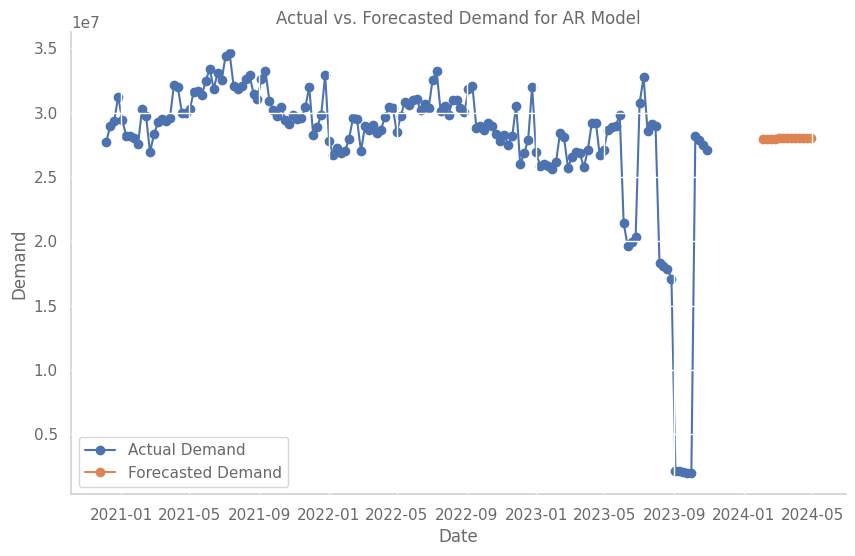

In [ ]:
# Load the dataset
data = Fact_Demand_data.copy()
data['DATE'] = pd.to_datetime(data['DATE'])
data.set_index('DATE', inplace=True)

# Extract the time series data (assuming 'UNIT_SALES' is the column to model)
time_series_data = data['UNIT_SALES']

# Check for missing values and handle them if necessary
time_series_data = time_series_data.dropna()

# Calculate weekly sales
weekly_sales = time_series_data.resample('W').sum()

# Train Autoregressive model
lag = 1  # Example lag parameter
model = AutoReg(weekly_sales, lags=lag)
results = model.fit()

# Forecast future demand
# Adjust forecast_steps to ensure it doesn't extend beyond the available data
forecast_steps = min(26, len(weekly_sales))
forecast = results.predict(start=len(weekly_sales), end=len(weekly_sales) + forecast_steps - 1, dynamic=False)

# Calculate actual values for the entire available data
actual_values = weekly_sales

# Initialize variables to store best period information
best_period_start = None
best_period_end = None
best_period_sum = -np.inf

# Iterate over each 13-week period to find the one with the highest sum of forecasted demand
for i in range(len(forecast) - 12):
    sum_demand = forecast.iloc[i:i+13].sum()
    if sum_demand > best_period_sum:
        best_period_sum = sum_demand
        best_period_start = forecast.index[i]
        best_period_end = forecast.index[i+12]

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(actual_values[-len(forecast):], forecast)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(actual_values[-len(forecast):], forecast)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate R-squared (R2)
r2 = r2_score(actual_values[-len(forecast):], forecast)

# Print the start and end dates of the period with the highest forecasted demand
print("Start date of the period with the highest forecasted demand:", best_period_start)
print("End date of the period with the highest forecasted demand:", best_period_end)

# Print actual_values to debug
print("\nActual values:")
print(actual_values)

# Print the forecasted demand for the best period
print("\nForecasted demand for the best period:")
print(forecast.loc[best_period_start:best_period_end])

# Print the evaluation metrics
print("\nEvaluation Metrics:")
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2):", r2)

# Plot the actual values and forecasted values
plt.figure(figsize=(10, 6))
plt.plot(actual_values, label='Actual Demand', marker='o')
plt.plot(forecast.loc[best_period_start:best_period_end], label='Forecasted Demand', marker='o')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.title('Actual vs. Forecasted Demand for AR Model')
plt.legend()
plt.grid(True)
plt.show()

## <a name = "arima"> </a> 4.2 ARIMA Model</a>

Start date of the period with the highest forecasted demand: 2024-02-04 00:00:00
End date of the period with the highest forecasted demand: 2024-04-28 00:00:00

Actual values:
DATE
2020-12-06   27710930.00
2020-12-13   28957110.00
2020-12-20   29367885.00
2020-12-27   31242480.00
2021-01-03   29456900.00
2021-01-10   28219809.00
2021-01-17   28217722.00
2021-01-24   28019183.00
2021-01-31   27555364.00
2021-02-07   30276207.00
2021-02-14   29745555.00
2021-02-21   26932968.00
2021-02-28   28305693.00
2021-03-07   29254628.00
2021-03-14   29532751.00
2021-03-21   29325438.00
2021-03-28   29580101.00
2021-04-04   32117606.00
2021-04-11   31982057.00
2021-04-18   29995220.00
2021-04-25   29980687.00
2021-05-02   30286401.00
2021-05-09   31613857.00
2021-05-16   31687760.00
2021-05-23   31334207.00
2021-05-30   32451043.00
2021-06-06   33414078.00
2021-06-13   31847347.00
2021-06-20   33101572.00
2021-06-27   32539314.00
2021-07-04   34439759.00
2021-07-11   34618091.00
2021-07-18   320840

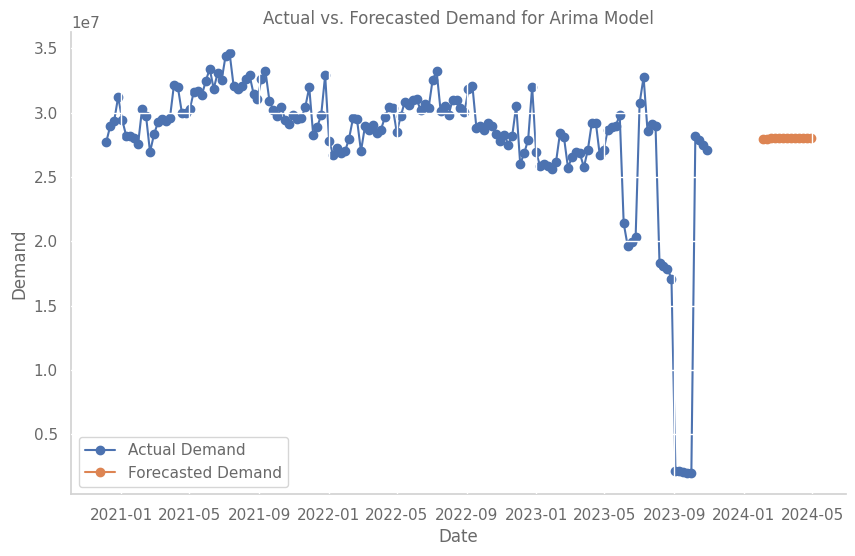

In [ ]:

from statsmodels.tsa.arima.model import ARIMA

# Load the dataset
data = Fact_Demand_data.copy()
data['DATE'] = pd.to_datetime(data['DATE'])
data.set_index('DATE', inplace=True)

# Extract the time series data (assuming 'UNIT_SALES' is the column to model)
time_series_data = data['UNIT_SALES']

# Check for missing values and handle them if necessary
time_series_data = time_series_data.dropna()

# Calculate weekly sales
weekly_sales = time_series_data.resample('W').sum()

# Train ARIMA model
order = (1, 0, 0)  # Example ARIMA order parameters (p, d, q)
model = ARIMA(weekly_sales, order=order)
results = model.fit()

# Forecast future demand
forecast_steps = min(26, len(weekly_sales))
forecast = results.predict(start=len(weekly_sales), end=len(weekly_sales) + forecast_steps - 1, dynamic=False)

# Calculate actual values for the entire available data
actual_values = weekly_sales

# Initialize variables to store best period information
best_period_start = None
best_period_end = None
best_period_sum = -np.inf

# Iterate over each 13-week period to find the one with the highest sum of forecasted demand
for i in range(len(forecast) - 12):
    sum_demand = forecast.iloc[i:i+13].sum()
    if sum_demand > best_period_sum:
        best_period_sum = sum_demand
        best_period_start = forecast.index[i]
        best_period_end = forecast.index[i+12]

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(actual_values[-len(forecast):], forecast)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(actual_values[-len(forecast):], forecast)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate R-squared (R2)
r2 = r2_score(actual_values[-len(forecast):], forecast)

# Print the start and end dates of the period with the highest forecasted demand
print("Start date of the period with the highest forecasted demand:", best_period_start)
print("End date of the period with the highest forecasted demand:", best_period_end)

# Print actual_values to debug
print("\nActual values:")
print(actual_values)

# Print the forecasted demand for the best period
print("\nForecasted demand for the best period:")
print(forecast.loc[best_period_start:best_period_end])

# Print the evaluation metrics
print("\nEvaluation Metrics:")
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2):", r2)

# Plot the actual values and forecasted values
plt.figure(figsize=(10, 6))
plt.plot(actual_values, label='Actual Demand', marker='o')
plt.plot(forecast.loc[best_period_start:best_period_end], label='Forecasted Demand', marker='o')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.title('Actual vs. Forecasted Demand for Arima Model')
plt.legend()
plt.grid(True)
plt.show()


## 4.2.1 <a name="aq1"></a> Question 1 with ARIMA

## Load and Explore the Dataset To Answer Question 1 from ARIMA Model</a>

Start date of the period with the highest forecasted demand: 2023-11-05 00:00:00
End date of the period with the highest forecasted demand: 2024-01-28 00:00:00

Actual values:
DATE
2020-12-06   6979.00
2020-12-13   5586.00
2020-12-20   4164.00
2020-12-27   3988.00
2021-01-03   3030.00
2021-01-10   2440.00
2021-01-17   2594.00
2021-01-24   2684.00
2021-01-31   2308.00
2021-02-07   2179.00
2021-02-14   2218.00
2021-02-21   2311.00
2021-02-28   2089.00
2021-03-07   2262.00
2021-03-14   2245.00
2021-03-21   2305.00
2021-03-28   2122.00
2021-04-04   2291.00
2021-04-11   2034.00
2021-04-18   2206.00
2021-04-25   2061.00
2021-05-02   1768.00
2021-05-09   2002.00
2021-05-16   1952.00
2021-05-23   2118.00
2021-05-30   2788.00
2021-06-06   4089.00
2021-06-13   4465.00
2021-06-20   5009.00
2021-06-27   5460.00
2021-07-04   6755.00
2021-07-11   5802.00
2021-07-18   4678.00
2021-07-25   4427.00
2021-08-01   3827.00
2021-08-08   3477.00
2021-08-15   3466.00
2021-08-22   3045.00
2021-08-29   3113.00


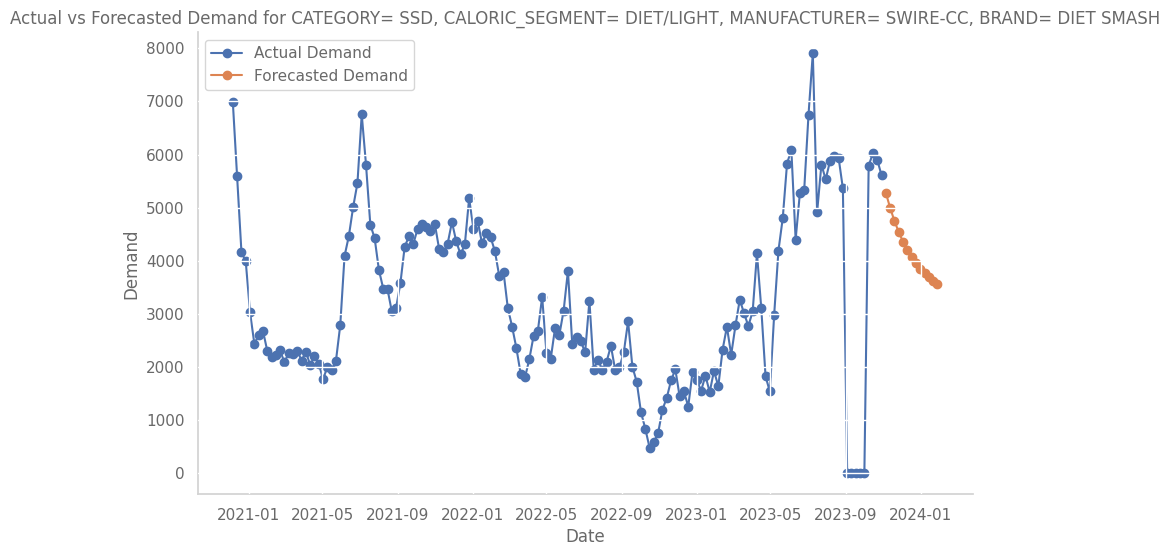

In [ ]:

from statsmodels.tsa.arima.model import ARIMA

# Load the dataset
data = Fact_Demand_data.copy()
data['DATE'] = pd.to_datetime(data['DATE'])
data.set_index('DATE', inplace=True)


# Apply filters to the dataset
category_data = data[(data['CATEGORY'] == 'SSD') & (data['CALORIC_SEGMENT'] == 'DIET/LIGHT') & (data['MANUFACTURER'] == 'SWIRE-CC') & (data['BRAND'] == 'DIET SMASH')]

# Extract the time series data (assuming 'UNIT_SALES' is the column to model)
time_series_data = category_data['UNIT_SALES']

# Check for missing values and handle them if necessary
time_series_data = time_series_data.dropna()

# Calculate weekly sales
weekly_sales = time_series_data.resample('W').sum()

# Train ARIMA model
order = (1, 0, 0)  # Example ARIMA order (p, d, q)
model = ARIMA(weekly_sales, order=order)
results = model.fit()

# Forecast future demand
# Adjust forecast_steps to ensure it doesn't extend beyond the available data
forecast_steps = min(26, len(weekly_sales))
forecast = results.predict(start=len(weekly_sales), end=len(weekly_sales) + forecast_steps - 1, dynamic=False)

# Calculate actual values for the entire available data
actual_values = weekly_sales

# Initialize variables to store best period information
best_period_start = None
best_period_end = None
best_period_sum = -np.inf

# Iterate over each 13-week period to find the one with the highest sum of forecasted demand
for i in range(len(forecast) - 12):
    sum_demand = forecast.iloc[i:i+13].sum()
    if sum_demand > best_period_sum:
        best_period_sum = sum_demand
        best_period_start = forecast.index[i]
        best_period_end = forecast.index[i+12]

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(actual_values[-len(forecast):], forecast)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(actual_values[-len(forecast):], forecast)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate R-squared (R2)
r2 = r2_score(actual_values[-len(forecast):], forecast)

# Print the start and end dates of the period with the highest forecasted demand
print("Start date of the period with the highest forecasted demand:", best_period_start)
print("End date of the period with the highest forecasted demand:", best_period_end)

# Print actual_values to debug
print("\nActual values:")
print(actual_values)

# Print the forecasted demand for the best period
print("\nForecasted demand for the best period:")
print(forecast.loc[best_period_start:best_period_end])

# Print the evaluation metrics
print("\nEvaluation Metrics:")
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2):", r2)

# Plot the actual values and forecasted values
plt.figure(figsize=(10, 6))
plt.plot(actual_values, label='Actual Demand', marker='o')
plt.plot(forecast.loc[best_period_start:best_period_end], label='Forecasted Demand', marker='o')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.title('Actual vs Forecasted Demand for CATEGORY= SSD, CALORIC_SEGMENT= DIET/LIGHT, MANUFACTURER= SWIRE-CC, BRAND= DIET SMASH')
plt.legend()
plt.grid(True)
plt.show()


## 4.2.2 <a name="aq3"></a> Question 3 with ARIMA

## Load and Explore the Dataset To Answer Question 3 from ARIMA Model</a>

Start date of the period with the highest forecasted demand: 2024-02-04 00:00:00
End date of the period with the highest forecasted demand: 2024-04-28 00:00:00

Actual values:
DATE
2020-12-06   4761.00
2020-12-13   4598.00
2020-12-20   4759.00
2020-12-27   4203.00
2021-01-03   4546.00
2021-01-10   4593.00
2021-01-17   4779.00
2021-01-24   4615.00
2021-01-31   4736.00
2021-02-07   4684.00
2021-02-14   4547.00
2021-02-21   4578.00
2021-02-28   4550.00
2021-03-07   4614.00
2021-03-14   4597.00
2021-03-21   4584.00
2021-03-28   3935.00
2021-04-04   3961.00
2021-04-11   3843.00
2021-04-18   3912.00
2021-04-25   4024.00
2021-05-02   3858.00
2021-05-09   4272.00
2021-05-16   4286.00
2021-05-23   4112.00
2021-05-30   3859.00
2021-06-06   3805.00
2021-06-13   3601.00
2021-06-20   3908.00
2021-06-27   3770.00
2021-07-04   3500.00
2021-07-11   3985.00
2021-07-18   4051.00
2021-07-25   3687.00
2021-08-01   4300.00
2021-08-08   4576.00
2021-08-15   4615.00
2021-08-22   4333.00
2021-08-29   4322.00


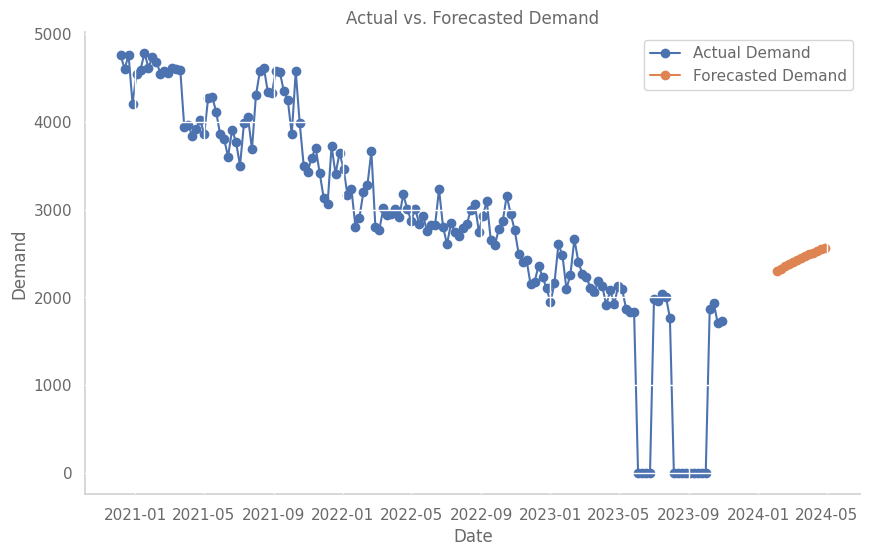

In [ ]:

from statsmodels.tsa.arima.model import ARIMA


# Load the dataset
data = Fact_Demand_data.copy()
data['DATE'] = pd.to_datetime(data['DATE'])
data.set_index('DATE', inplace=True)

# Apply filters to the dataset
category_data = data[(data['CATEGORY'] == 'ENERGY') & (data['CALORIC_SEGMENT'] == 'DIET/LIGHT') & (data['MANUFACTURER'] == 'SWIRE-CC') & (data['BRAND'] == 'VENOMOUS BLAST')]

# Extract the time series data (assuming 'UNIT_SALES' is the column to model)
time_series_data = category_data['UNIT_SALES']

# Check for missing values and handle them if necessary
time_series_data = time_series_data.dropna()

# Calculate weekly sales
weekly_sales = time_series_data.resample('W').sum()

# Train ARIMA model
order = (1, 0, 0)  # Example ARIMA order (p, d, q)
model = ARIMA(weekly_sales, order=order)
results = model.fit()

# Forecast future demand
# Adjust forecast_steps to ensure it doesn't extend beyond the available data
forecast_steps = min(26, len(weekly_sales))
forecast = results.predict(start=len(weekly_sales), end=len(weekly_sales) + forecast_steps - 1, dynamic=False)

# Calculate actual values for the entire available data
actual_values = weekly_sales

# Initialize variables to store best period information
best_period_start = None
best_period_end = None
best_period_sum = -np.inf

# Iterate over each 13-week period to find the one with the highest sum of forecasted demand
for i in range(len(forecast) - 12):
    sum_demand = forecast.iloc[i:i+13].sum()
    if sum_demand > best_period_sum:
        best_period_sum = sum_demand
        best_period_start = forecast.index[i]
        best_period_end = forecast.index[i+12]

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(actual_values[-len(forecast):], forecast)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(actual_values[-len(forecast):], forecast)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate R-squared (R2)
r2 = r2_score(actual_values[-len(forecast):], forecast)

# Print the start and end dates of the period with the highest forecasted demand
print("Start date of the period with the highest forecasted demand:", best_period_start)
print("End date of the period with the highest forecasted demand:", best_period_end)

# Print actual_values to debug
print("\nActual values:")
print(actual_values)

# Print the forecasted demand for the best period
print("\nForecasted demand for the best period:")
print(forecast.loc[best_period_start:best_period_end])

# Print the evaluation metrics
print("\nEvaluation Metrics:")
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2):", r2)

# Plot the actual values and forecasted values
plt.figure(figsize=(10, 6))
plt.plot(actual_values, label='Actual Demand', marker='o')
plt.plot(forecast.loc[best_period_start:best_period_end], label='Forecasted Demand', marker='o')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.title('Actual vs. Forecasted Demand')
plt.legend()
plt.grid(True)
plt.show()


**Key Findings and Results:**
During this phase, AR and ARIMA modeling techniques were applied to analyze the performance of UNIT_SALES. Out of these, ARIMA stands out for further analysis with respect to different filters to address questions 1 and 3.

**For Question 1:** The analysis reveals a period from **November 5, 2023, to January 28, 2024**, exhibiting the highest forecasted demand for the specified product category "SSD", caloric segment "DIET/LIGHT", manufacturer "SWIRE-CC", and brand "DIET SMASH". This suggests a potential surge in consumer interest during this time.

**For Question 3:** The analysis identifies a period from **February 4, 2024, to April 28, 2024**, with the highest forecasted demand for the specified product category "ENERGY", caloric segment "DIET/LIGHT", manufactured by "SWIRE-CC", and branded "VENOMOUS BLAST". This indicates a potential surge in consumer interest during this time.

However, notable discrepancies exist between forecasted and actual sales data, as evidenced by high error metrics MAE and RMSE and a negative R-squared value. This underscores the necessity for improvements in the forecasting model to better capture market dynamics.

# <a name = "Conclusion"> </a> 5. Conclusion


The application of ARIMA modeling techniques yielded insightful findings for both Question 1 and Question 3, highlighting periods of heightened forecasted demand within specific product categories, caloric segments, manufacturers, and brands. However, the notable disparities between forecasted and actual sales data, indicated by high error metrics and a negative R-squared value, underscore the imperative for refining the forecasting model to more accurately capture market dynamics and enhance predictive capabilities.

# <a name = "group"> </a> 6. Contribution


1. **Sushma Sree Mutyapu:** My contribution begins with untangling the complexities of our dataset by offering essential context and understanding in various ways. I initiated the modeling process by conducting thorough data exploration, employing AR and ARIMA techniques to analyze the performance of UNIT_SALES. ARIMA proved particularly insightful, guiding our focus on addressing Questions 1 and 3. By meticulously filtering and analyzing data, I identified key periods of heightened forecasted demand, providing actionable insights into consumer behavior. My contributions facilitated informed decision-making processes, aiding the team in understanding consumer preferences and market